### MAST30034: Applied Data Science Project 1
---
# Data Analysis: FHVHV Dataset
#### Xavier Travers (1178369)

Performs data analysis to relate the COVID dataset and FHVHV aggregate dataset

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame, Column, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

# add homemade helpers
sys.path.insert(1, '../scripts')
import helpers.join_helpers as jh
import helpers.plot_helpers as ph

DEBUGGING = False

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/09 22:25:21 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.20.85.51 instead (on interface eth0)
22/08/09 22:25:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/09 22:25:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/09 22:25:23 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/09 22:25:23 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
# read in the aggregated yellow tlc data
yellow_df = spark.read.parquet('../data/curated/tlc/aggregated/yellow/')
yellow_df.limit(5)

year,cdc_week,week_index,pu_borough,do_borough,passengers,num_*,tot_trip_distance,avg_trip_distance
2018,28,28,Manhattan,Staten Island,0.0,2,38.3,19.15
2018,29,29,Manhattan,EWR,4.0,113,2015.0299999999988,17.8321238938053
2018,30,30,Queens,Queens,6.0,914,5293.399999999994,5.791466083150978
2018,30,30,Manhattan,Brooklyn,0.0,283,1834.8999999999996,6.483745583038868
2018,31,31,Manhattan,Bronx,3.0,389,3279.1499999999996,8.42969151670951


In [4]:
# read in the aggregated covid data
covid_df = spark.read.parquet('../data/curated/virals/covid/cases-by-week/')
covid_df.limit(5)

year,cdc_week,week_index,borough,tot_cases,avg_cases,tot_deaths,avg_deaths,tot_hospitalised,avg_hospitalised
2020,41,145,Staten Island,229.0,32.714285714285715,2.0,0.2857142857142857,19.0,2.7142857142857144
2022,25,234,Staten Island,1174.0,167.71428571428572,6.0,0.8571428571428571,60.0,8.571428571428571
2021,37,194,Staten Island,852.0,121.71428571428571,6.0,0.8571428571428571,47.0,6.714285714285714
2021,29,186,Staten Island,442.0,63.142857142857146,2.0,0.2857142857142857,30.0,4.285714285714286
2020,51,155,Staten Island,1954.0,279.14285714285717,33.0,4.714285714285714,127.0,18.142857142857142


In [5]:
# join the datasets by week_index
joined_df = jh.join_by_week_by_borough(yellow_df, covid_df, 'tot_cases')
joined_df.limit(5)

do_borough,prev_week_index,pu_borough,year,cdc_week,week_index,passengers,num_*,tot_trip_distance,avg_trip_distance,pu_tot_cases,do_tot_cases
Manhattan,134,Manhattan,2020,31,135,1.0,124034,244819.8800000037,1.9738126642695044,393.0,393.0
Queens,134,Manhattan,2020,31,135,1.0,3036,23537.320000000003,7.752740447957841,393.0,515.0
Manhattan,153,Manhattan,2020,50,154,1.0,236327,441120.1699999967,1.8665669601865074,2842.0,2842.0
Queens,123,Queens,2020,20,124,1.0,901,4095.1,4.545061043285239,2551.0,2551.0
Manhattan,128,Manhattan,2020,25,129,1.0,74342,150614.20999999816,2.0259639234887166,367.0,367.0


In [6]:
# first, aggregate on number of passengers > 1
joined_df = joined_df\
    .where(F.col('passengers') >= 2)\
    .groupBy('week_index', 'do_borough')\
    .agg(
        F.sum('do_tot_cases').alias('do_tot_cases'),
        F.sum('num_*').alias('num_trips'),
        (F.sum('num_*') / 7).alias('avg_trips')
    )
joined_df.limit(5)

week_index,do_borough,do_tot_cases,num_trips,avg_trips
123,Manhattan,28854.0,8791,1255.857142857143
153,Bronx,41004.0,656,93.71428571428571
140,Queens,6060.0,1986,283.7142857142857
155,Bronx,52672.0,634,90.57142857142857
149,Brooklyn,22406.0,2485,355.0


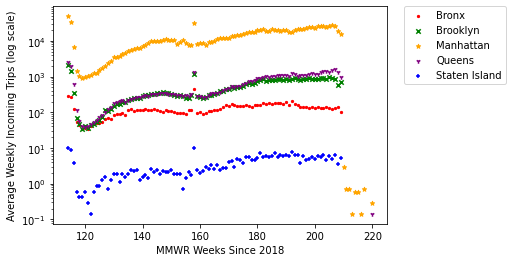

In [9]:
# plot a time-series histogram to show how average weekly trips changes per week
ph.group_plot(joined_df.toPandas(), 'week_index', 'avg_trips',
    'do_borough', filename_prefix = 'yellow-covid', kind = 'scatter',
    xlabel = 'MMWR Weeks Since 2018', 
    ylabel = 'Average Weekly Incoming Trips', logy=True)

In [ ]:
borough_part = Window.partitionBy('do_borough')
joined_df.withColumn('min_avg_trips', F.min('avg_trips').over(borough_part))\
    .where(F.col('avg_trips') == F.col('min_avg_trips'))\
    .drop('min_avg_trips')

The above quite clearly demonstrates the prevalent COVID-19 dip at around March-April 2020 when lockdowns started and predicted outcomes (for everything, were at an all-time low).

In [ ]:
# plot a general/dirty scatter plot of avg wkly trips vs cases from prev wk
ph.group_plot(joined_df.toPandas(), 'do_tot_cases', 'avg_trips',
    'do_borough', filename_prefix = 'yellow-covid', 
    xlabel = 'Previous Week New Cases', 
    ylabel = 'Average Weekly Incoming Trips',
    logx=True, logy=True)